In [92]:
# compute
import numpy as np
import pandas as pd
import keras

# data io
import glob
import deepdish as dd
import sys
sys.path.append('../')

# image
import cv2

# plot
import matplotlib.pyplot as plt
%matplotlib inline

# spykes
from spykes.neuropop import NeuroPop
from spykes.neurovis import NeuroVis

# stats
from scipy.stats import circmean

# machine learning
import xgboost as xgb

# local
import V4pyutils as V4

from sklearn.manifold import TSNE, MDS, SpectralEmbedding

### Load data

In [2]:
h5path = '../V4pydata/H5data/M3/'
data = pd.read_excel('/home/klab/Projects/02-V4py/V4py/V4pydata/natural_artificial.xlsx')
data_M3 = data[data['Animal']=='M3']

df = pd.read_pickle('../02-preprocessed_data/M3/merged_art_data_across_sessions')

df_neurons = pd.read_pickle('../02-preprocessed_data/M3/data_to_combine_across_sessions')

nat_df = pd.read_pickle('../02-preprocessed_data/M3/merged_nat_data_across_sessions')

nat_features = pd.read_pickle('../02-preprocessed_data/M3/precomputed_nat_features')

In [123]:
## Get neural responses to hues
hue_responses = np.array()
for neuron_id, neuron_name in enumerate(df_neurons['name']):

    art_sessions_of_interest = df_neurons.loc[neuron_id]['art_sessions']
    df_sessions_of_interest = df.loc[df['session.number'].isin(art_sessions_of_interest)]
    Y = df_sessions_of_interest[neuron_name].values
    np.concatenate(hue_responses,Y)
    
    hues = df_sessions_of_interest['predictors.hue'].values
    


TypeError: Required argument 'object' (pos 1) not found

In [124]:
hue_responses.shape

(90,)

### Build VGG model

In [3]:
vgg_model_l7= V4.vgg_transfer_ari(n_pops=1,
                      verbose=0)

### Compute codebooks for artificial stimuli and visualize low-d manifold

#### Get VGG features

In [4]:
hue = np.linspace(0, 359, 360)
rgb_list = list()

Xplain_vgg = list()
stimpath = '../V4pydata'

#for stim_id in range(360):
for a, ang in V4.tqdm(enumerate(hue)):
    imname = '/stimuli/M3/Hues/img%03d.jpg' % np.floor(ang)
    filename = stimpath + imname
    I = V4.load_and_preprocess_ari(filename)
    rgb_list.append(np.round(I[0,0,0,:][::-1]+[103.939,116.779,123.68][::-1]))

    Xplain_vgg.append(np.squeeze(vgg_model_l7.predict(I)))
Xplain_vgg = np.array(Xplain_vgg)

360it [00:11, 41.39it/s]


### Perform low-d embedding

In [129]:
se = SpectralEmbedding(n_components=2)
X_lowd = se.fit_transform(Xplain_vgg)

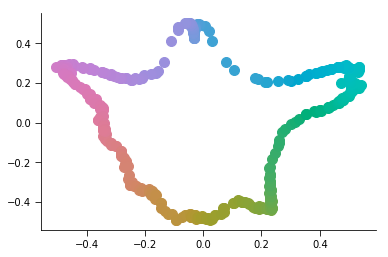

In [130]:
plt.figure()
ax = plt.subplot(111)
for im in range(X_lowd.shape[0]):
    ax.plot(X_lowd[im, 0], X_lowd[im, 1], 'o', ms=10, c=rgb_list[im].astype(float) / 255.0)
V4.simpleaxis(ax)
plt.show()

#### Build RDM matrix

Should each example should be in range 0-1, 0 being identical and 1 being maximally different?

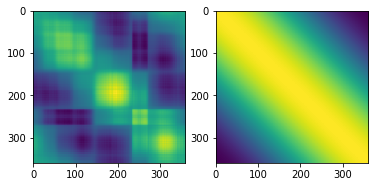

In [70]:
rdm_response = np.dot(X_lowd,X_lowd.transpose())
plt.subplot(121)
plt.imshow(rdm_response,interpolation='none')



plt.subplot(122)
dist_matrix = np.zeros((360,360))
for a in range(360):
    for b in range(a,360):
        diff = 1-(b-a)/360.
        dist_matrix[a,b] = dist_matrix[b,a] = diff
        
chord_length_mat = -2*np.sin(np.pi*(1-dist_matrix-.5))
plt.imshow(chord_length_mat,interpolation='none')



Build a general method for printing the correlation given data matrix

In [105]:
from scipy.stats import kendalltau as kt
#scipy.stats.weightedtau

def vectorize(mat):
    """Takes a square symmetric matrix mat and returns the vectorized form. Like matlab's squareform"""
    assert mat.shape[0]==mat.shape[1]
    
    vec = mat[:,0]
    for row in range(1,mat.shape[1]):
        vec = np.concatenate((vec,mat[row:,row]))
    
    return vec

def RDM_corr(datas, hues = False, method = 'correlation'):
    """Returns a symmetric matrix with the correlation between RDMs 
    corresponding to the data matrices in datas
    
    datas = list of high-dimensional data arrays
    hues = boolean, whether to include an artificial 'Hue similarity' matrix
    method = {'correlation','MDS','SE'}
                """
    assert isinstance(datas,list)
    
    RDMs = list()
    
    if method is 'correlation':
        embed = lambda x: np.corrcoef(x)
    elif method is 'SE':
        embed = SpectralEmbedding(n_components=2)
    elif method is 'MDS':
        embed = MDS(n_components=2)
    else:
        raise NotImplemented
    
    # get low-D representations
    for data in datas:
        if method is 'correlation':
            rdm_response = np.corrcoef(data)
        else:
            X_lowd = embed.fit_transform(Xplain_vgg)
            rdm_response = np.dot(X_lowd,X_lowd.transpose())
            
        RDMs.append(vectorize(rdm_response))
    
    if hues:
        dist_matrix = np.zeros((360,360))
        for a in range(360):
            for b in range(a,360):
                diff = 1-(b-a)/360.
                dist_matrix[a,b] = dist_matrix[b,a] = diff
        RDMs.append(vectorize(dist_matrix)) 
    
    ks = np.ones((len(RDMs),len(RDMs)))
    
    for a in range(len(RDMs)):
        for b in range(a,len(RDMs)):
            k = kt(RDMs[a],RDMs[b]).correlation
            ks[a,b] = ks[b,a] = k
            
    return ks

In [106]:
RDM_corr([Xplain_vgg],hues = True, method = 'correlation')

array([[ 1.        ,  0.28508253],
       [ 0.28508253,  1.        ]])

In [131]:
3+3+.25*9+3+.75*9+3+6

27.0